In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

from solardatatools import signal_decompositions as sd
from solardatatools.signal_decompositions_osd import osd_l2_l1d1_l2d2p365
from gfosd import Problem 
from gfosd.components import *

np.random.seed(12) # reload each time to get first instance of seed

# Set up simple numerical examples for tests

- objective val compare, relative to rms of signal
- testing 3 func: cvxpy, osd+cvx,  osd+qss --> maybe just add one of these do the abstract
- times when weights in osd are not the same

## Three-Component Signal 

In [2]:
t = np.linspace(0, 1000, 365*2)

signal1 = np.sin(2 * np.pi * t / 365) # 365
signal2 = signal.square(2 * np.pi * t / 450) 

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

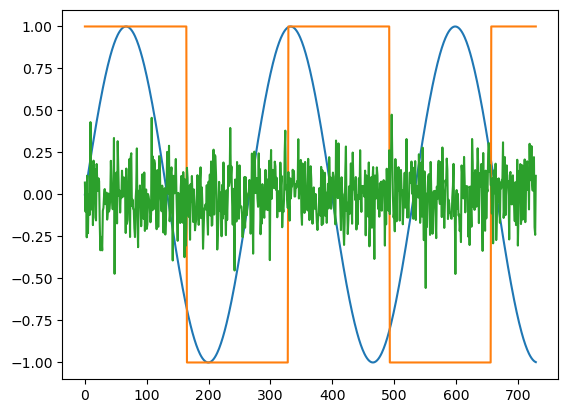

In [3]:
plt.plot(signal1)
plt.plot(signal2)
plt.plot(X_real[0])

In [12]:
# same struc as my signal

# c1 and c2
# c1: 2
# c2: 500


# c1 = SumSquare(weight=1/T)

# # periodic sine, c2 param from sdt
# c2 = Aggregate([
#     SumSquare(weight=150*1000/T, diff=2)
# ])
# # piecewise, c1 param from sdt
# c3 = Aggregate([
#     SumAbs(weight=0.9/T, diff=1),
#     Inequality(vmax=1, vmin=-1),])




# components = [c1, c2, c3]
# problem = Problem(y, components)
# problem.decompose(solver='QSS', verbose=False)

# RMS Signal

In [70]:
rms = np.sqrt(np.mean(y**2))
rms

1.213499775141423

# CVXPY + MOSEK
Next
- OSD + CVXPY/MOSEK
- OSD + QSS

In [19]:
expected_s_hat_mosek, expected_s_seas_mosek, expected_s_error_mosek, cvx_obj = sd.l2_l1d1_l2d2p365(y, c1=0.8, c2=1, solver="MOSEK")

In [30]:
expected_s_hat_osd_mosek, expected_s_seas_osd_mosek, expected_s_error_osd_mosek, osd_cvx_obj = osd_l2_l1d1_l2d2p365(y, w1=0.8*len(y), w2=1*len(y), solver="MOSEK")

In [31]:
expected_s_hat_osd_mosek, expected_s_seas_osd_mosek, expected_s_error_osd_mosek, osd_qss_obj = osd_l2_l1d1_l2d2p365(y, w1=0.8*len(y), w2=1*len(y), solver="QSS")

In [29]:
print("RMS ", rms)
print("CVX ", cvx_obj)
print("OSD ", osd_cvx_obj)
print("QSS ", osd_qss_obj)

RMS  1.213499775141423
CVX  42.33561023808318
OSD  0.027318725932328005
QSS  0.02731872612820902


# simple example

In [93]:
c1 = SumSquare(weight=1/T)
c2 = Aggregate([
    SumSquare(weight=1e3/T, diff=2),
#     Periodic(T=len(y), period=500)
])
c3 = Aggregate([
    SumAbs(weight=1e0/T, diff=1),
    Inequality(vmax=1, vmin=-1),
    
])


components = [c1, c2, c3]

problem = Problem(y, components)

In [78]:
# matching cvx
# c1 = SumSquare(weight=10)
# c2 = Aggregate([
#     SumSquare(weight=500, diff=2),
# #     Periodic(T=len(y), period=500)
# ])
# c3 = Aggregate([
#     SumAbs(weight=10, diff=1),
#     Inequality(vmax=1, vmin=-1),
    
# ])


# components = [c1, c2, c3]

# problem = Problem(y, components)

In [94]:
problem.decompose(solver="MOSEK")
print(problem.objective_value)
s_error =  problem.decomposition[0]
s_seas = problem.decomposition[1]
s_hat = problem.decomposition[2]

osd_decomp = [s_error, s_seas, s_hat]

0.01962104512376186


In [95]:
problem.decompose(solver="qss")
print(problem.objective_value)
s_error =  problem.decomposition[0]
s_seas = problem.decomposition[1]
s_hat = problem.decomposition[2]

qss_decomp = [s_error, s_seas, s_hat]

0.019617561861700113


### equivalent CVXPY + MOSEK

In [37]:
import cvxpy as cvx

In [96]:
residual_weights = np.ones_like(y)
tv_weights = np.ones(len(y) - 1)
index_set = ~np.isnan(y)

In [113]:
c0=1/T # ADD WEIGHT FOR RESIDUAL
c2=1e3/T 
c1=5/T


# c0=10
# c2=500
# c1=10

In [114]:
s_hat = cvx.Variable(len(y))
s_seas = cvx.Variable(len(y))
s_error = cvx.Variable(len(y))

c1 = cvx.Constant(value=c1)
c2 = cvx.Constant(value=c2)


objective = cvx.Minimize(

        c0 * cvx.norm(cvx.multiply(residual_weights, s_error))
        + c1 * cvx.norm1(cvx.multiply(tv_weights, cvx.diff(s_hat, k=1)))
        + c2 * cvx.norm(cvx.diff(s_seas, k=2))
    )

constraints = [
    y[index_set] == s_hat[index_set] + s_seas[index_set] + s_error[index_set],
    cvx.sum(s_seas[:365]) == 0,
]

In [115]:
problem = cvx.Problem(objective=objective, constraints=constraints)
problem.solve(solver="MOSEK")

cvx_decomp = [s_error.value, s_seas.value, s_hat.value]

In [100]:
rms

1.213499775141423

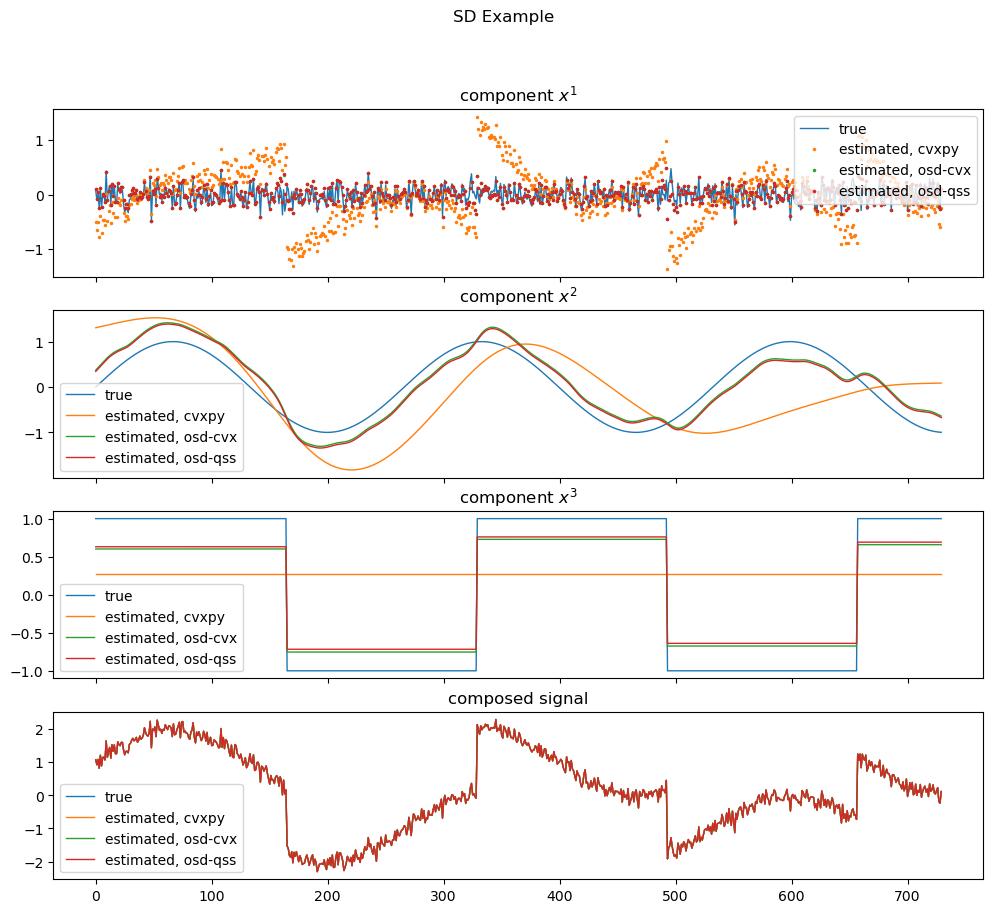

In [116]:
# cvx_decomp = np.array([osd_s_error, osd_s_seas, osd_s_hat])
# osd_decomp = np.array([osd_s_error, osd_s_seas, osd_s_hat])
# qss_decomp = np.array([osd_s_error, osd_s_seas, osd_s_hat])

fig, axs = plt.subplots(4, sharex=True, figsize=(12,10))
fig.suptitle('SD Example')

# x1: noise
axs[0].plot(X_real[0], label="true", linewidth=1)
axs[0].plot(cvx_decomp[0], label="estimated, cvxpy", linewidth=0, marker=".",  markersize=3)
axs[0].plot(osd_decomp[0], label="estimated, osd-cvx", linewidth=0, marker=".", markersize=3)
axs[0].plot(qss_decomp[0], label="estimated, osd-qss", linewidth=0, marker=".", markersize=3)
axs[0].set_title("component $x^1$")

# x2: periodic
axs[1].plot(X_real[1], label="true", linestyle="-", linewidth=1)
axs[1].plot(cvx_decomp[1], label="estimated, cvxpy", linewidth=1)
axs[1].plot(osd_decomp[1], label="estimated, osd-cvx", linewidth=1)
axs[1].plot(qss_decomp[1], label="estimated, osd-qss", linewidth=1)
axs[1].set_title("component $x^2$")


# x3: piecewise
axs[2].plot(X_real[2], label="true", linestyle="-", linewidth=1)
axs[2].plot(cvx_decomp[2], label="estimated, cvxpy", linewidth=1)
axs[2].plot(osd_decomp[2], label="estimated, osd-cvx", linewidth=1)
axs[2].plot(qss_decomp[2], label="estimated, osd-qss", linewidth=1)
axs[2].set_title("component $x^3$")

# sum
axs[3].plot(y, label="true", linestyle="-", linewidth=1)
mosek_signal = np.array([expected_s_error_mosek,expected_s_seas_mosek,expected_s_hat_mosek])
axs[3].plot(np.sum(np.array(cvx_decomp), axis=0), label="estimated, cvxpy", linewidth=1)
axs[3].plot(np.sum(np.array(osd_decomp), axis=0), label="estimated, osd-cvx", linewidth=1)
axs[3].plot(np.sum(np.array(qss_decomp), axis=0), label="estimated, osd-qss", linewidth=1)
axs[3].set_title("composed signal")


for i in range(len(axs)):
    axs[i].legend()

# Plot


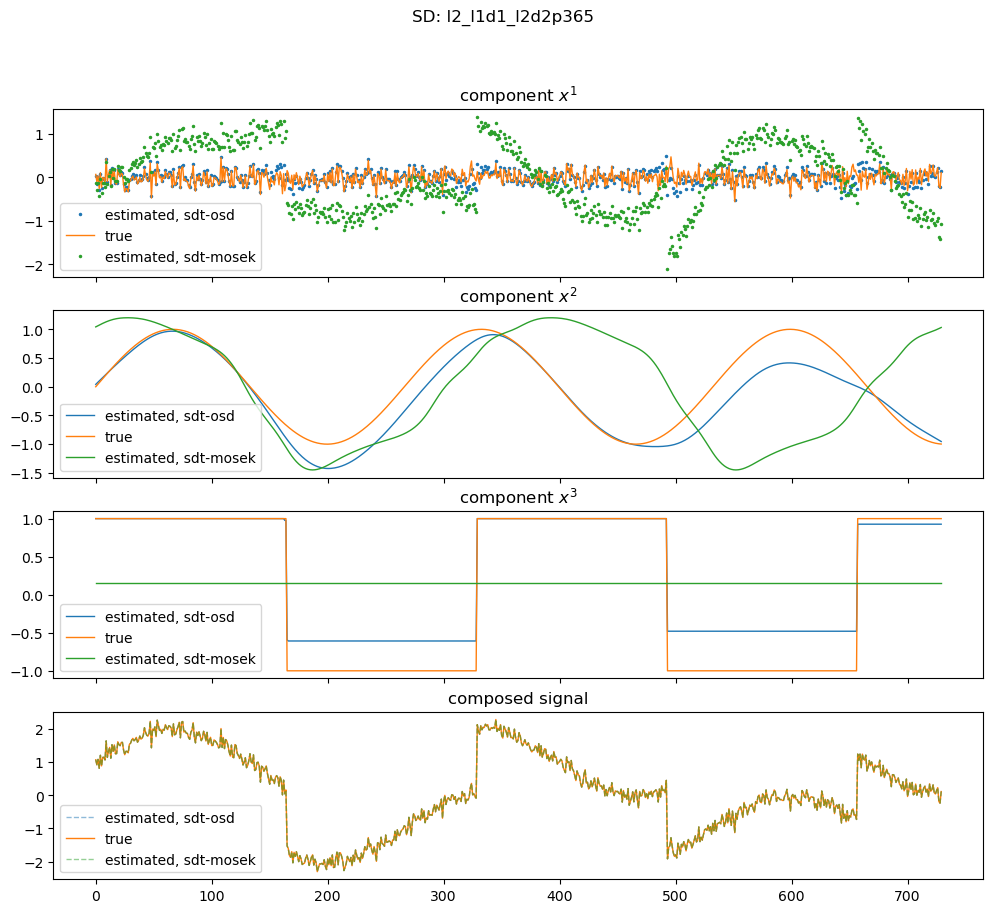

In [26]:
qss_decomp_new = np.array([osd_s_error, osd_s_seas, osd_s_hat])

fig, axs = plt.subplots(4, sharex=True, figsize=(12,10))
fig.suptitle('SD: l2_l1d1_l2d2p365')

# x1: noise
axs[0].plot(qss_decomp_new[0], label="estimated, sdt-osd", linewidth=0, marker=".", markersize=3)
axs[0].plot(X_real[0], label="true", linewidth=1)
axs[0].plot(expected_s_error_mosek, label="estimated, sdt-mosek", linewidth=0, marker=".",  markersize=3)
axs[0].set_title("component $x^1$")

# x2: periodic
axs[1].plot(qss_decomp_new[1], label="estimated, sdt-osd", linewidth=1)
axs[1].plot(X_real[1], label="true", linestyle="-", linewidth=1)
axs[1].plot(expected_s_seas_mosek, label="estimated, sdt-mosek", linewidth=1)
axs[1].set_title("component $x^2$")


# x3: piecewise
axs[2].plot(qss_decomp_new[2], label="estimated, sdt-osd", linewidth=1)
axs[2].plot(X_real[2], label="true", linestyle="-", linewidth=1)
axs[2].plot(expected_s_hat_mosek, label="estimated, sdt-mosek", linewidth=1)
axs[2].set_title("component $x^3$")

# sum
axs[3].plot(qss_decomp_new.sum(axis=0), label="estimated, sdt-osd", linestyle="--", alpha=0.5, linewidth=1)
axs[3].plot(y, label="true", linestyle="-", linewidth=1)
mosek_signal = np.array([expected_s_error_mosek,expected_s_seas_mosek,expected_s_hat_mosek])
axs[3].plot(mosek_signal.sum(axis=0), label="estimated, sdt-mosek", linestyle="--", alpha=0.5, linewidth=1)
axs[3].set_title("composed signal")


for i in range(len(axs)):
    axs[i].legend()